<a href="https://colab.research.google.com/github/omerhac/osic-fibrosis/blob/master/exponent_functions_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# imports 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# images path
IMAGES_GCS_PATH = 'gs://osic_fibrosis/images-norm/images-norm'

In [5]:
# clone and copy repository
!git clone https://github.com/omerhac/osic-fibrosis.git
!cp -r osic-fibrosis/* ./

Cloning into 'osic-fibrosis'...
remote: Enumerating objects: 432, done.
remote: Counting objects: 100% (432/432), done.
remote: Compressing objects: 100% (279/279), done.
remote: Total 800 (delta 283), reused 278 (delta 149), pack-reused 368
Receiving objects: 100% (800/800), 71.81 MiB | 34.39 MiB/s, done.
Resolving deltas: 100% (513/513), done.


# View one prediction graph

In [11]:
import predict 
import visualize

# plot one patient predicted graph
exp_gen = predict.exponent_generator(IMAGES_GCS_PATH + '/validation')
#id, func = next(exp_gen)
#visualize.plot_patient_exp(id, exp_function=func)

In [7]:
import table_data
exp_dict = table_data.get_exp_fvc_dict()
train_table = table_data.get_train_table()

# create exponent functiosn dict
func_dict = {}
for id in exp_dict:
  i_week, i_fvc = table_data.get_initial_fvc(id)
  func_dict[id] = predict.ExpFunc(i_fvc, exp_dict[id], i_week)


# Check Laplace Log Lokilhood for ground truth coefficients

In [10]:
import metrics

def metric_check(func_dict, n_patients, inifinite=False, theta=150):
    """Average n_patients random train patients Laplace Log Likelihood score"""
    scores = []

    # get scores
    for i, id in enumerate(func_dict):
        func = func_dict[id]

        # custom theta
        if isinstance(theta, dict):
          theta_now = theta[id]
        else:
          theta_now = theta
        score = metrics.get_lll_value_exp_function(id, func, theta=theta_now)
        scores.append(score)

        # exit rule
        if inifinite:
            print(score) # for infinitely printing scores
        else:
            if i == n_patients - 1:
                break

    return sum(scores) / n_patients
  
  
metric_check(func_dict, 170)

-6.442046429353045

In [ ]:
metrics.metric_check(exp_gen, 14)

## Thats pretty close to the metric value we get from the CNN predicting the exponential coefficients. Thus, we should persue other methods for improving the model other then improving the CNN.

# Check how much effect does theta have

In [13]:
# get a very good theta 
theta_dict = {}
weeks_dict = {} # for later use

# iterate threw all train patients
for id in func_dict:
  hist = table_data.get_fvc_hist(train_table, id)
  theta = np.abs(hist["FVC"] - func_dict[id](hist["Weeks"])) # compute theta as the absolute diff of a prediction from ground truth
  theta_dict[id] = theta
  weeks_dict[id] = hist["Weeks"]

metric_check(func_dict, 170, theta=theta_dict) # best theta possible

-6.031767030104632

## So theta has a big inflence on the metric!
~ Now lets see if there is any pattern in theta against week number

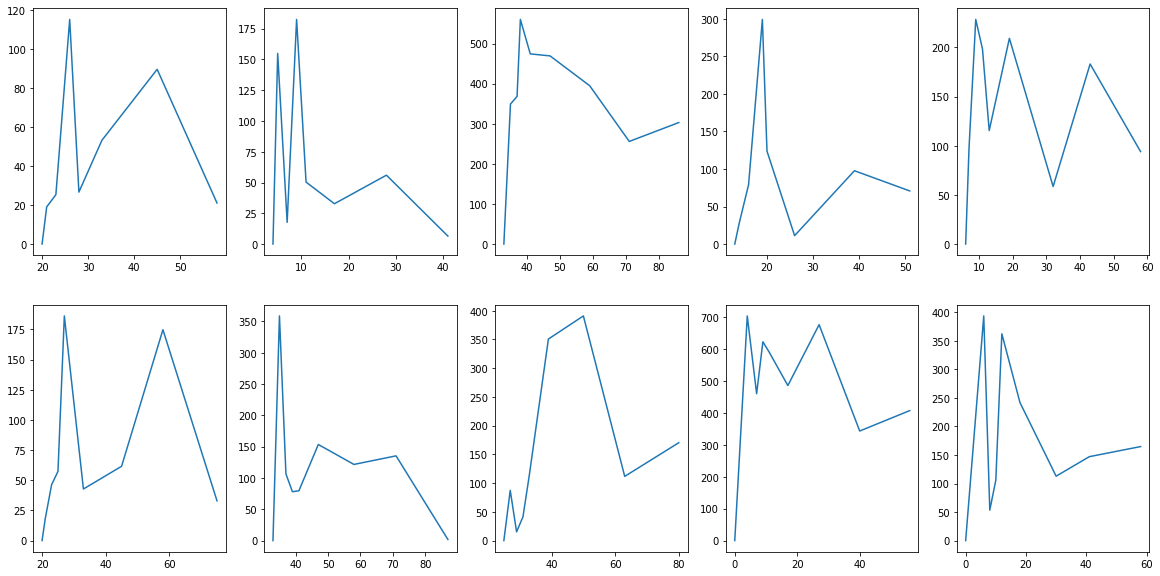

In [14]:
import math
N_SAMPLES = 10

# initiate plot
n_rows = math.ceil(N_SAMPLES / 5)
n_cols = 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))


# plot
for plot in range(N_SAMPLES):
  id = np.random.choice(list(theta_dict)) # generate random sample

  # get data
  theta = theta_dict[id]
  weeks = weeks_dict[id]

  # plot theta
  ax[plot // 5, plot % 5].plot(weeks, theta)

plt.show()

# Plot n_samples of ground truth exponent functions

<Figure size 1440x360 with 0 Axes>

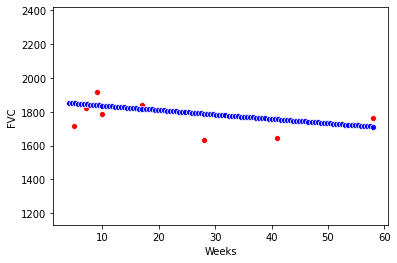

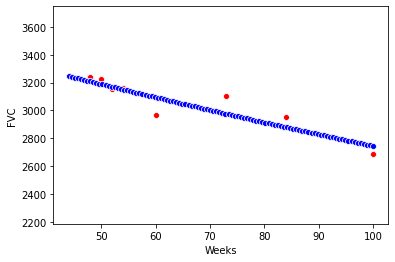

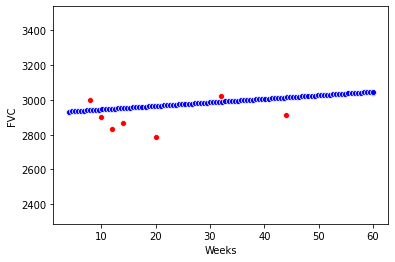

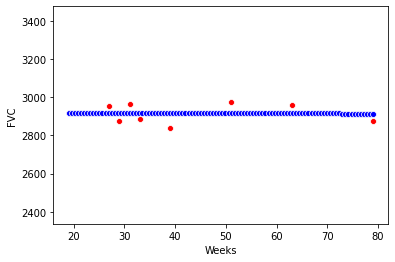

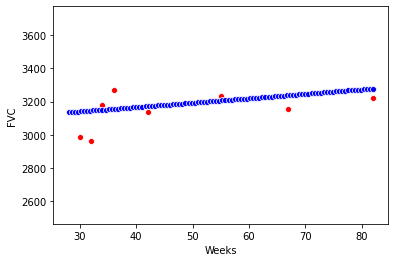

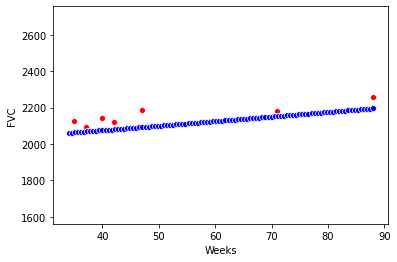

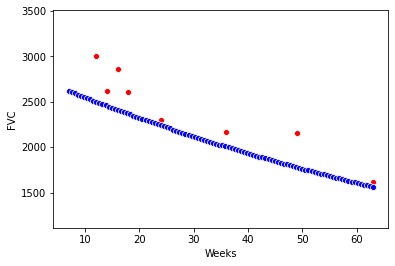

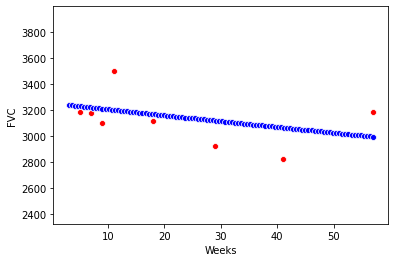

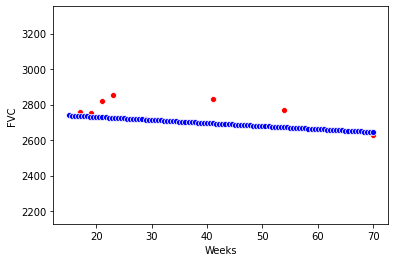

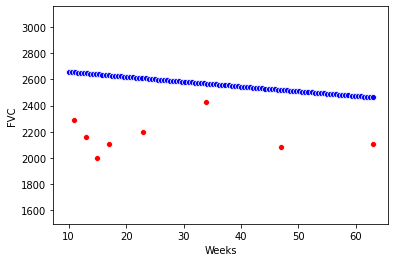

In [15]:
N_SAMPLES = 10

# plot
plt.figure(figsize=(20, 5))
for plot in range(N_SAMPLES):
  id = np.random.choice(list(func_dict))
  func = func_dict[id]
  visualize.plot_patient_exp(id, exp_function=func)

# Exemine outliers
## Plot 12 FVC diagrams and the cooks distance for every point

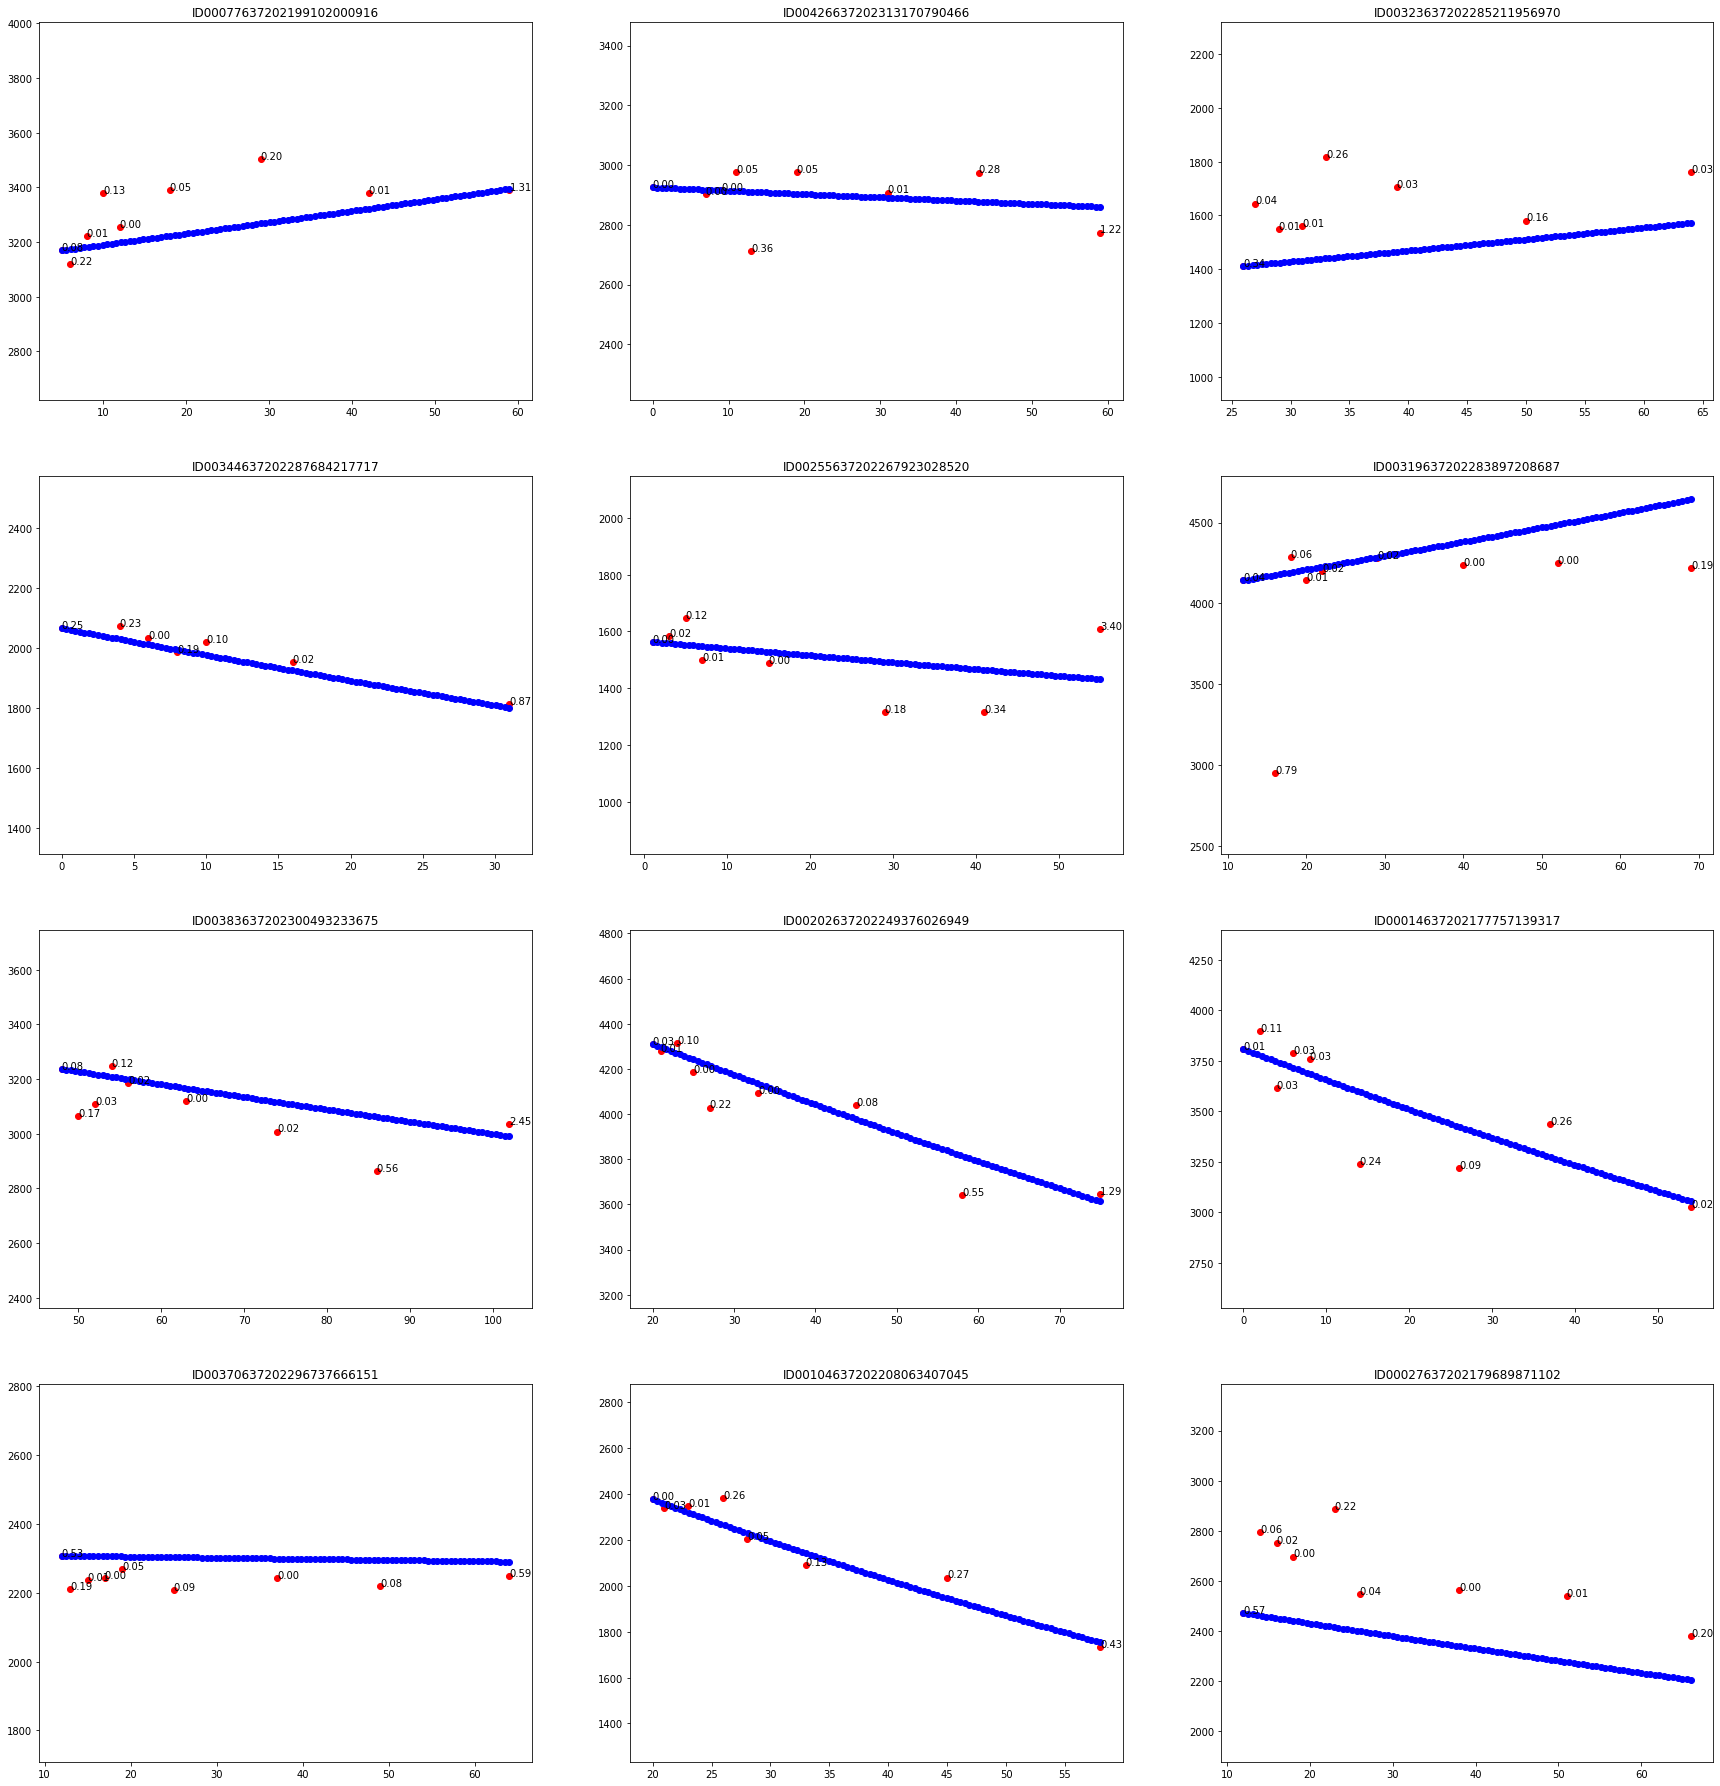

In [58]:
from statsmodels.formula.api import ols
N_SAMPLES = 12

# initiate plot
n_rows = math.ceil(N_SAMPLES / 3)
n_cols = 3
fig, ax = plt.subplots(n_rows, n_cols, figsize=(30, 8 * n_rows))

for plot in range(N_SAMPLES):
  id = np.random.choice(train_table["Patient"].unique())  # select a random sample
  hist = table_data.get_fvc_hist(train_table, id)

  # get cooks distance
  m = ols("FVC ~ Weeks", hist).fit() # fit a statsmodels ols
  infl = m.get_influence() # check influens on every point
  cooks_dists = infl.summary_frame()["cooks_d"] # show cooks distance for every point
  # plot
  visualize.plot_patient_exp(id, func_dict[id], ax=ax[plot//3, plot % 3])
  ax[plot//3, plot%3].set_title(id)
  
  # anotetae cooks distance
  for i, dist in enumerate(cooks_dists):
    ax[plot//3, plot%3].annotate('{0:.2f}'.format(dist), (hist["Weeks"].iloc[i], hist["FVC"].iloc[i]))

plt.show()

## Now lets try to remove from each graph the point with the largest cooks distance which is not the first or the last point

In [72]:
def get_cooks_distance(observations):
  """Return the cooks distance of every point in observations"""
  x, y = observations.columns  # get predictor and response variable

  m = ols("{} ~ {}".format(x, y), observations).fit() # fit a statsmodels ols
  infl = m.get_influence() # check influens on every point
  cooks_dists = infl.summary_frame()["cooks_d"] # show cooks distance for every poin

  return cooks_dists


def remove_outlier(fvc_hist):
  """Remove the point with the largest cooks distance from the fvc observations. Do not remove the first nor the last point"""
  max_ind = get_cooks_distance(fvc_hist)[1:-1].argmax() + 1# remove first and last
  fvc_hist = fvc_hist.reset_index()
  return fvc_hist.drop(max_ind, axis=0)


def get_patient_fvc_exp(hist):
    """Get a patient exponential coefficient.
    Each patient has his own fvc progression that can be described by Ie^-kt.
    Wheres I is the initial FCV measure, k is the exponential coefficient and t is time.
    Args:
        table--data table with records
    """

    # compute logs
    weeks = hist["Weeks"]
    log_fvc = np.log(hist["FVC"])

    # center weeks - set 0 for first measurement
    weeks = weeks - hist.iloc[0, 0]

    # regress to find logI -kt
    neg_k, logI = np.polyfit(weeks, log_fvc, deg=1)

    return -neg_k

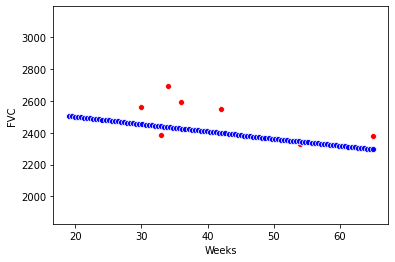

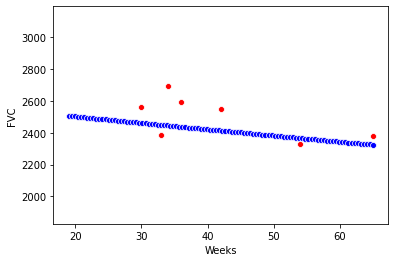

In [117]:
# ID00408637202308839708961
id = "ID00030637202181211009029"
visualize.plot_patient_exp(id, exp_function=func_dict[id])
hist = table_data.get_fvc_hist(train_table, id)

# remove outliers
hist_corrected = remove_outlier(hist)
hist_corrected = remove_outlier(hist)

# fit second exponent
i_week, i_fvc = table_data.get_initial_fvc(id)
k = get_patient_fvc_exp(hist_corrected)
new_exp = predict.ExpFunc(i_fvc, k, i_week)

visualize.plot_patient_exp(id, exp_function=new_exp)


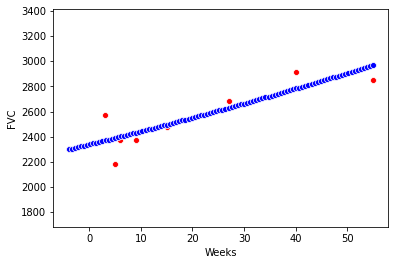

ID00076637202199015035026


In [124]:
id = np.random.choice(list(func_dict))
visualize.plot_patient_exp(id, exp_function=func_dict[id])
print(id)

# Case study: Patient "ID00007637202177411956430"

In [ ]:
# visualize fvc
visualize.plot_patient_exp("ID00007637202177411956430")

In [ ]:
# visualize log of exp
hist = table_data.get_fvc_hist(train_table, "ID00007637202177411956430") # get hist
log_fvc = np.log(hist["FVC"])
plt.scatter(hist["Weeks"], log_fvc)

In [ ]:
# show cooks distance
log_hist = hist.copy()
log_hist["FVC"] = log_fvc
m = ols("FVC ~ Weeks", log_hist).fit() # fit ols
infl = m.get_influence()
cooks_d = infl.summary_frame()["cooks_d"]
print(cooks_d)

In [ ]:
points = np.linspace(1, 50, 25)
y = [np.exp(-0.05 * point) for point in points]
print(y)
plt.scatter(points, y)

In [ ]:
plt.scatter(points, np.log(y))